# <center> **Spectral Clustering** </center>
#### Métodos Numéricos II, 2021
#### Alan Reyes-Figueroa

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
import scipy.sparse.linalg as ln

from PIL import Image

from time import time
from math import exp, sqrt

In [2]:
from spClust2 import jit_similarity, imageGraph_sparse, normalizedLaplacian, shiftTrick
from spClust2 import plotEigen, showFiedler

## Construct the graph of the image

In [3]:
def imageGraph_sparse(I, std=1., alpha=1., beta=1., p=0.):
    ''' Constructs the affinity matrix of an image I.
        Inputs:  I      = RGB input image as numpy array of shape (h,w,3).
                 sigma  = standard deviation (to be called in the similarity function). Default sigma = 1.
                 alpha, beta = weights for the spatial and color components in similarity function.
                               Default values 0.5.
        Output:  W      = affinity matrix of I.
    '''
    #If = I.reshape(-1,3)
    (h, w) = I.shape[:2]      # shape of image
    sh = h*w                  # shape of graph matrix W
      
    # fill W
    coords = []
    for i in range(0, h):
        for j in range(0, w-1):
            sim = jit_similarity(i, j, i, j+1, I[i,j,:], I[i,j+1,:], h, w, sigma, alpha, beta)
            coords.append([sim, i*w+j, i*w+(j+1)])
            coords.append([sim, i*w+(j+1), i*w+j])

    for i in range(0, h-1):
        for j in range(0, w):
            sim = jit_similarity(i, j, i+1, j, I[i,j,:], I[i+1,j,:], h, w, sigma, alpha, beta)
            coords.append([sim, i*w+j, (i+1)*w+j])
            coords.append([sim, (i+1)*w+j, i*w+j])
            
    # add randoms
    radds = []
    for pix in range(0, sh-2):
        q = int(p * (sh-pix-2))
        if (q > 0):
            ll = list(np.arange(pix+2, sh))
            if (pix+w in ll): ll.remove(pix+w)
            ll = np.array(ll)
            sel = np.random.permutation(np.arange(len(ll)))[:q]
            i = pix//w
            j = pix - i*w
            for s in sel:
                ii = s//w
                jj = s - ii*w
                sim = jit_similarity(i, j, ii, jj, I[i,j,:], I[ii,jj,:], h, w, sigma, alpha, beta)
                radds.append([sim, pix, s])
                radds.append([sim, s, pix])
        
    # define sparse matrix
    coords = np.array(coords)
    radds  = np.array(radds)
    W = sp.coo_matrix((coords[:,0], (coords[:,1], coords[:,2])), shape=(sh,sh))
    if (len(radds) > 0):
        R = sp.coo_matrix((radds[:,0], (radds[:,1], radds[:,2])), shape=(sh,sh))
        W = W + R
    return W

## Load image

In [4]:
# load image (and resize)
I0 = Image.open('plane.jpg')
factor = 0.25

I = I0.resize((int(factor*I0.size[0]), int(factor*I0.size[1])), Image.LANCZOS)
J = I = np.asarray(I)
#I = I[120:270, 170:440, :]
(h, w, ch) = I.shape[:3]

#I = rgb2luv(I)
# normalize image to [0,1]
I = I - I.min()
I = I / I.max()
print('image size:', I.shape[:2])

image size: (80, 120)


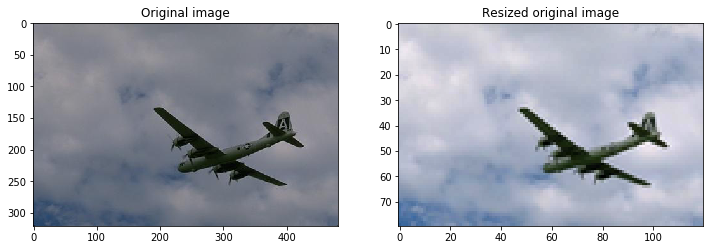

In [5]:
# display (resized) image
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.imshow(I0)
plt.title('Original image')
plt.subplot(1,2,2)
plt.imshow(I)
plt.title('Resized original image')
plt.show()

## Construct affinity matrix

In [6]:
Iflat = I.reshape(-1,3)
(h,w) = I.shape[:2]
sh = Iflat.shape[0]
print('shape: ({}, {})'.format(h,w))
print('flated shape: {}'.format(sh))

sigma = I.std()
alpha = 0.1
beta = 1.0
p = 0.005
tic = time()
W = imageGraph_sparse(I, sigma, alpha, beta, p)
toc = time()
print('graph construction time: {} seconds'.format(toc-tic))

shape: (80, 120)
flated shape: 9600
graph construction time: 7.887587785720825 seconds


In [7]:
W.shape

(9600, 9600)

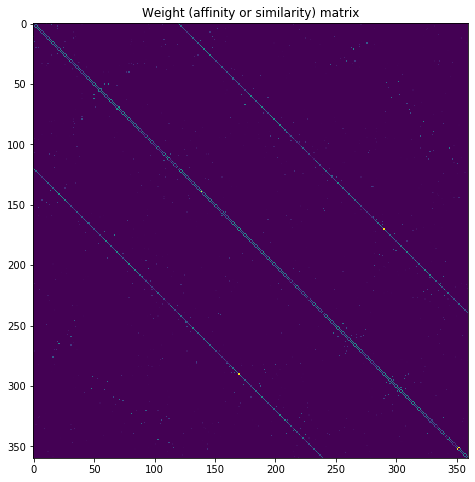

In [8]:
plt.figure(figsize=(8,8))
plt.imshow(W.todense()[:3*w,:3*w])
plt.title('Weight (affinity or similarity) matrix')
plt.show()

## Spectral analysis

In [9]:
# computing Normalized Laplacian
L = normalizedLaplacian(W)

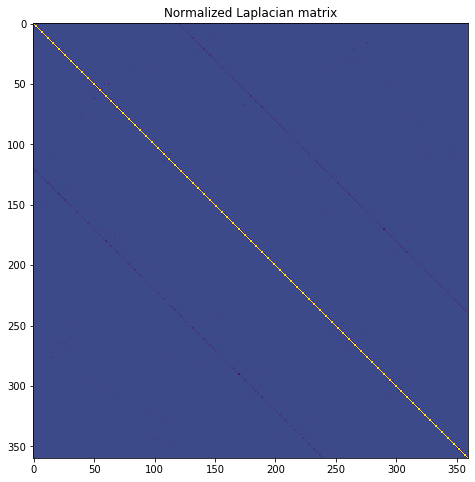

In [10]:
plt.figure(figsize=(8,8))
plt.imshow(L.todense()[:3*w,:3*w])
plt.title('Normalized Laplacian matrix')
plt.show()

In [11]:
dim = 5
l, V = shiftTrick(W, sh, dim)

eigenvalues: [8.79663276e-09 3.30261519e-05 8.50875294e-05 1.88764465e-04
 3.33052390e-04]

eigenvectors: [[-1.19069538e-02  9.00188326e-04  2.23963753e-05 -6.54457659e-05
   2.82837324e-06]
 [-1.27526608e-02  9.64137174e-04  2.43534575e-05 -7.02567236e-05
   2.62694275e-06]
 [-1.13972984e-02  8.61765917e-04  2.18953649e-05 -6.28837308e-05
   2.21411139e-06]
 [-1.11515369e-02  8.43086155e-04  2.10547180e-05 -6.13297026e-05
   2.56253292e-06]
 [-1.29638470e-02  9.80307642e-04  2.52105217e-05 -7.16945956e-05
   2.19115853e-06]]


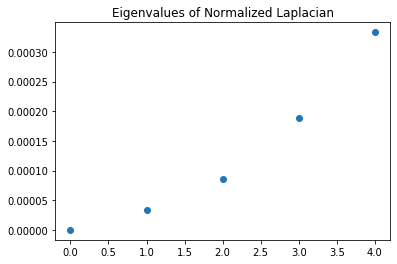

In [12]:
plotEigen(l, V, dim)

## Image binarization using Fiedler vector

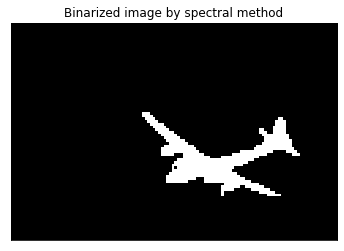

In [13]:
showFiedler(V, (h,w), inv=1)